In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Source https://github.com/yutkin/lenta.ru-news-dataset

import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/Common/lenta-ru-news.csv')

In [ ]:
df.date = pd.to_datetime(df.date)
df['year'] = df.date.dt.year

In [ ]:
df = df.drop(df[(df.year == 1914)|(df.year == 1999)].index)
print(df.text.isna().sum())
df.dropna(subset=['text'], inplace=True)

Based on Fine-tune a language model tutorial: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/language_modeling.ipynb

In [ ]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00


In [ ]:
# ! pip install datasets transformers
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.8 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

model_checkpoint ='ai-forever/ruBert-base'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, 
                                          padding=True, truncation=True)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
from datasets import Dataset, DatasetDict

def get_datasets(df, year):
    train_size = int(0.9 * df.shape[0])
    train = df.sample(n=train_size)
    validation = df.drop(train.index)

    news_datasets = DatasetDict({'train': Dataset.from_pandas(train[['text']]), 
                            'validation': Dataset.from_pandas(validation[['text']])})
    news_datasets['train'] = news_datasets['train'].remove_columns('__index_level_0__')
    news_datasets['validation'] = news_datasets['validation'].remove_columns('__index_level_0__')

    tokenized_datasets = news_datasets.map(tokenize_function, batched=True, 
                                           num_proc=4, remove_columns=["text"])
    lm_datasets = tokenized_datasets.map(group_texts, batched=True, 
                                         batch_size=1000, num_proc=4)
    
    lm_datasets.save_to_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/dataset_sber_128_{year}')

In [ ]:
from tqdm import tqdm

for year in tqdm(range(2000, 2020), leave=False):
    get_datasets(df[df.year == year], year)

In [ ]:
from datasets import load_from_disk, concatenate_datasets
from tqdm import tqdm

lm_datasets = None

for year in tqdm(range(2000, 2020)):
    if lm_datasets is None:
        lm_datasets = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/dataset_sber_128_{year}')
    else:
        temp_datasets = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/dataset_sber_128_{year}')
        lm_datasets['train'] = concatenate_datasets([lm_datasets['train'], temp_datasets['train']])
        lm_datasets['validation'] = concatenate_datasets([lm_datasets['validation'], temp_datasets['validation']])

100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


In [ ]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1534335
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 170504
    })
})

In [ ]:
import numpy as np

# Divide randomly our whole dataset into 10 parts
length = len(lm_datasets['train'])
all_indices = set([i for i in range(length)])
rest_indices = all_indices.copy()
num_examples = int(0.1 * length)

indices_train = {}

for i in range(9):
    indices_train[f'indices_{i}'] = np.random.choice(list(rest_indices), size=num_examples, replace=False)
    rest_indices = rest_indices - set(indices_train[f'indices_{i}'])
indices_train['indices_9'] = np.array(list(rest_indices))

length = len(lm_datasets['validation'])
all_indices = set([i for i in range(length)])
rest_indices = all_indices.copy()
num_examples = int(0.1 * length)

indices_val = {}

for i in range(9):
    indices_val[f'indices_{i}'] = np.random.choice(list(rest_indices), size=num_examples, replace=False)
    rest_indices = rest_indices - set(indices_val[f'indices_{i}'])
indices_val['indices_9'] = np.array(list(rest_indices))

In [ ]:
for i in tqdm(range(10)):
    datadict = DatasetDict({})
    datadict['train'] = Dataset.from_dict(lm_datasets['train'][indices_train[f'indices_{i}']])
    datadict['validation'] = Dataset.from_dict(lm_datasets['validation'][indices_val[f'indices_{i}']])
    print(datadict)
    datadict.save_to_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/dataset_sber_128_part{i}')

  0%|          | 0/10 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 10%|█         | 1/10 [01:27<13:03, 87.03s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 20%|██        | 2/10 [02:34<10:05, 75.72s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 30%|███       | 3/10 [03:43<08:27, 72.47s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 40%|████      | 4/10 [04:52<07:06, 71.10s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 50%|█████     | 5/10 [05:56<05:42, 68.43s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 60%|██████    | 6/10 [06:59<04:27, 66.76s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 70%|███████   | 7/10 [08:04<03:18, 66.09s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 80%|████████  | 8/10 [09:08<02:11, 65.55s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153433
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17050
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153433 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17050 [00:00<?, ? examples/s]

 90%|█████████ | 9/10 [10:13<01:05, 65.18s/it]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 153438
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17054
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/153438 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/17054 [00:00<?, ? examples/s]

100%|██████████| 10/10 [11:15<00:00, 67.55s/it]


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import load_from_disk
from tqdm import tqdm

# Fine-tune the model
for i in tqdm(range(10)):
    print('Load the model')
    tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/BERT/tokenizer/', use_fast=True)
    model = AutoModelForMaskedLM.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Tehsis/Models/News/BERT/')
    
    model_name = 'ruBert-base'
    training_args = TrainingArguments(
        f"{model_name}-finetuned-news",
        evaluation_strategy = "epoch",
        num_train_epochs = 1.0,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        push_to_hub=False,
    )
    
    # Do the masking
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

    datasets = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/dataset_sber_128_part{i}')

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=datasets["train"],
        eval_dataset=datasets["validation"],
        data_collator=data_collator,
    )

    print(f'Train with dataset part{i}')
    trainer.train()
    print(f'Saving the model after training with part{i}')
    trainer.save_model('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/BERT')
    tokenizer.save_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/BERT/tokenizer/')
    print(f'Model saved for part{i}')

  0%|          | 0/2 [00:00<?, ?it/s]

Load the model
Train with dataset part8


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,1.300700,1.190930


Saving the model after training with part8


 50%|█████     | 1/2 [2:09:39<2:09:39, 7779.33s/it]

Model saved for part8
Load the model


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train with dataset part9


Epoch,Training Loss,Validation Loss


Find all occurences of shared words to construct word prototypes and then find words with the most significant semantic shift

In [ ]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=2d030439572262c8e5e0451ec3fcaa4d02182e544a02f2c13e9a25377924f89d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/BERT/tokenizer/', use_fast=True)
model = AutoModelForMaskedLM.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/Thesis/Models/News/BERT/', output_hidden_states=True)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
import torch 

def get_bert_embeddings(input, bert_model):
    with torch.no_grad():
        outputs = bert_model(torch.tensor(input['input_ids']).unsqueeze(dim=0).to(device),
                              token_type_ids=torch.tensor(input['token_type_ids']).unsqueeze(dim=0).to(device),
                              attention_mask=torch.tensor(input['attention_mask']).unsqueeze(dim=0).to(device))
        embeddings = outputs.hidden_states[-1][0, :, :].cpu().numpy()
    return embeddings

In [ ]:
import json

with open('/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/Data/shared_words_news.json', 'r') as f:
    words = json.load(f)
words = [w[0] for w in words.items()]

In [ ]:
import pymorphy2
from datasets import load_from_disk
from tqdm import tqdm
import json
import numpy as np

model.eval()
years = [2019, 2000]

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

morph = pymorphy2.MorphAnalyzer()

for year in tqdm(years):
    dataset = load_from_disk(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/dataset_sber_128_{year}')
    words_dict = {'words': {}, 'count': {}}
    part = 0
    for i in tqdm(range(len(dataset['train']))):
        tokenized_text = tokenizer.convert_ids_to_tokens(dataset['train'][i]['input_ids'])
        lemmas = [morph.parse(w)[0].normal_form for w in tokenized_text]
        useful = False
        for word in words:
            if word in lemmas:
                useful = True
                break
        if useful:
            embeds = get_bert_embeddings(dataset['train'][i], model)
            for word in words:
                if word in lemmas:
                    for j, lem in enumerate(lemmas):
                        if lem == word:
                            embedding = embeds[j]
                            if word not in words_dict['words']:
                                words_dict['words'][word] = embedding
                                words_dict['count'][word] = 1
                            else:
                                words_dict['words'][word] = words_dict['words'][word] + embedding
                                words_dict['count'][word] += 1
        if i % 10000 == 0 and i != 0:
            for k, v in tqdm(words_dict['words'].items()):
                words_dict['words'][k] = words_dict['words'][k].tolist()
            with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/word_prototypes/bert_words_dict_news_lem_{part}_{year}.json', 'w', encoding='utf-8') as f:
                json.dump(words_dict, f)
            part += 1
            words_dict = {'words': {}, 'count': {}}               
    
    for i in tqdm(range(len(dataset['validation']))):
        tokenized_text = tokenizer.convert_ids_to_tokens(dataset['validation'][i]['input_ids'])
        lemmas = [morph.parse(w)[0].normal_form for w in tokenized_text]
        useful = False
        for word in words:
            if word in lemmas:
                useful = True
                break
        if useful:
            embeds = get_bert_embeddings(dataset['validation'][i], model)
            for word in words:
                if word in lemmas:
                    for j, lem in enumerate(lemmas):
                        if lem == word:
                            embedding = embeds[j]
                            if word not in words_dict['words']:
                                words_dict['words'][word] = embedding
                                words_dict['count'][word] = 1
                            else:
                                words_dict['words'][word] = words_dict['words'][word] + embedding
                                words_dict['count'][word] += 1

    for k, v in tqdm(words_dict['words'].items()):
          words_dict['words'][k] = words_dict['words'][k].tolist()
    
    with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/word_prototypes/bert_words_dict_news_lem_{part}_{year}.json', 'w', encoding='utf-8') as f:
        json.dump(words_dict, f)

Выходные данные были обрезаны до нескольких последних строк (5000).
 42%|████▏     | 9999/23798 [11:16<20:53, 11.01it/s]

  0%|          | 0/3789 [00:00<?, ?it/s]

100%|██████████| 3789/3789 [00:00<00:00, 16808.14it/s]

 77%|███████▋  | 18437/23798 [20:50<05:08, 17.36it/s]

In [ ]:
import json
import numpy as np
from tqdm import tqdm

words_dict_2019 = {}

for i in tqdm(range(12)):
    if not words_dict_2019:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/word_prototypes/bert_words_dict_news_lem_{i}_2019.json', 'r', encoding='utf-8') as f:
            words_dict_2019 = json.load(f)
    else:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/word_prototypes/bert_words_dict_news_lem_{i}_2019.json', 'r', encoding='utf-8') as f:
            words_dict_temp = json.load(f)
        for w in words_dict_temp['words'].keys():
            if w in words_dict_2019['words']:
                words_dict_2019['words'][w] = np.array(words_dict_2019['words'][w]) + np.array(words_dict_temp['words'][w])
                words_dict_2019['count'][w] = int(words_dict_2019['count'][w]) + int(words_dict_temp['count'][w]) 
            else:
                words_dict_2019['words'][w] = np.array(words_dict_temp['words'][w])
                words_dict_2019['count'][w] = int(words_dict_temp['count'][w])

embeds_2019 = {}
for w in words_dict_2019['words'].keys():
    embeds_2019[w] = np.array(words_dict_2019['words'][w]) / int(words_dict_2019['count'][w])

  8%|▊         | 1/12 [00:08<01:28,  8.05s/it]

454


 17%|█▋        | 2/12 [00:12<01:01,  6.17s/it]

845


 25%|██▌       | 3/12 [00:17<00:48,  5.37s/it]

1320


 33%|███▎      | 4/12 [00:24<00:49,  6.20s/it]

1773


 42%|████▏     | 5/12 [00:28<00:36,  5.23s/it]

2194


 50%|█████     | 6/12 [00:30<00:25,  4.23s/it]

2605


 58%|█████▊    | 7/12 [00:34<00:20,  4.00s/it]

3056


 67%|██████▋   | 8/12 [00:40<00:19,  4.86s/it]

3524


 75%|███████▌  | 9/12 [00:45<00:14,  4.75s/it]

3989


 83%|████████▎ | 10/12 [00:48<00:08,  4.42s/it]

4423


 92%|█████████▏| 11/12 [00:52<00:04,  4.12s/it]

4846


100%|██████████| 12/12 [00:56<00:00,  4.68s/it]

5461


In [ ]:
words_dict_2000 = None
for i in range(3):
    if words_dict_2000 is None:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/word_prototypes/bert_words_dict_news_lem_{i}_2000.json', 'r', encoding='utf-8') as f:
            words_dict_2000 = json.load(f)
    else:
        with open(f'/content/gdrive/MyDrive/Colab Notebooks/Thesis/Data/News/BERT/word_prototypes/bert_words_dict_news_lem_{i}_2000.json', 'r', encoding='utf-8') as f:
            words_dict_temp = json.load(f)
        for w in words_dict_temp['words'].keys():
            if w in words_dict_2000['words']:
                words_dict_2000['words'][w] = np.array(words_dict_2000['words'][w]) + np.array(words_dict_temp['words'][w])
                words_dict_2000['count'][w] = int(words_dict_2000['count'][w]) + int(words_dict_temp['count'][w]) 
            else:
                words_dict_2000['words'][w] = np.array(words_dict_temp['words'][w])
                words_dict_2000['count'][w] = int(words_dict_temp['count'][w])

embeds_2000 = {}
for w in words_dict_2000['words'].keys():
    embeds_2000[w] = np.array(words_dict_2000['words'][w]) / int(words_dict_2000['count'][w])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

cosine_similarities ={}

words = set(words_dict_2019['words'].keys()).intersection(set(words_dict_2000['words'].keys()))

for word in tqdm(words):
    cosine_similarities[word] = cosine_similarity([embeds_2000[word]], 
                                                  [embeds_2019[word]])[0][0]
                                                  
top_20 = sorted(cosine_similarities.items(), key=lambda item: item[1])[:20]
top_20

100%|██████████| 3791/3791 [00:01<00:00, 3189.75it/s]


[('зелёный', 0.4808397350807502),
 ('цик', 0.5202007931154593),
 ('наряд', 0.6476647263947887),
 ('напомнить', 0.6588486724783555),
 ('лента', 0.6712656610800256),
 ('боец', 0.6730268491327227),
 ('ру', 0.6813194966047434),
 ('четвёрка', 0.6816827931817029),
 ('дон', 0.6820923826435209),
 ('кадр', 0.7097397803188367),
 ('правый', 0.7345344168069061),
 ('подъём', 0.7406148621345177),
 ('рада', 0.7420017173044472),
 ('правда', 0.7426860583756876),
 ('барак', 0.7463360483385253),
 ('миля', 0.7630201066094356),
 ('редакция', 0.763954120653666),
 ('яблоко', 0.7645209141343252),
 ('корт', 0.7684283686473639),
 ('единство', 0.7691534495973326)]

In [ ]:
for word in top_20:
    cosine_similarities_2000 = {}
    cosine_similarities_2019 = {}
    for w in words:
        cosine_similarities_2000[w] = cosine_similarity([embeds_2000[word[0]]], 
                                                        [embeds_2000[w]])[0][0]
        cosine_similarities_2019[w] = cosine_similarity([embeds_2019[word[0]]], 
                                                        [embeds_2019[w]])[0][0]
    print(word[0])
    print(sorted(cosine_similarities_2000.items(), key=lambda item: item[1], reverse=True)[:6])
    print(sorted(cosine_similarities_2019.items(), key=lambda item: item[1], reverse=True)[:6])

зелёный
[('зелёный', 1.0), ('красный', 0.6884003102041343), ('цвет', 0.6401650633828444), ('голубой', 0.6312366762839308), ('лесной', 0.5875395264542924), ('гореть', 0.5776824010953476)]
[('зелёный', 1.0), ('президент', 0.5819738004139864), ('президентский', 0.5602524851041046), ('путин', 0.5405460346161971), ('украинский', 0.5368323589410893), ('украина', 0.5325510689574122)]
цик
[('цик', 0.9999999999999996), ('избирком', 0.5679318093764225), ('комиссия', 0.5226893543424938), ('президиум', 0.5113006743882191), ('правление', 0.5029413440340214), ('комитет', 0.4894093713713961)]
[('цик', 1.0000000000000009), ('солнечный', 0.44394793816222894), ('операционный', 0.42830403880794676), ('дерево', 0.4219758289036039), ('дождь', 0.4180644643255339), ('чайка', 0.4152969652967202)]
наряд
[('наряд', 1.0000000000000004), ('патруль', 0.7308122743614593), ('отряд', 0.6987959444206324), ('бригада', 0.6678905622892909), ('патрульный', 0.6132502720043469), ('вызов', 0.6025097241210622)]
[('наряд', 1.0

In [ ]:
vectors_2000 = embeds_2000
vectors_2019 = embeds_2019

100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


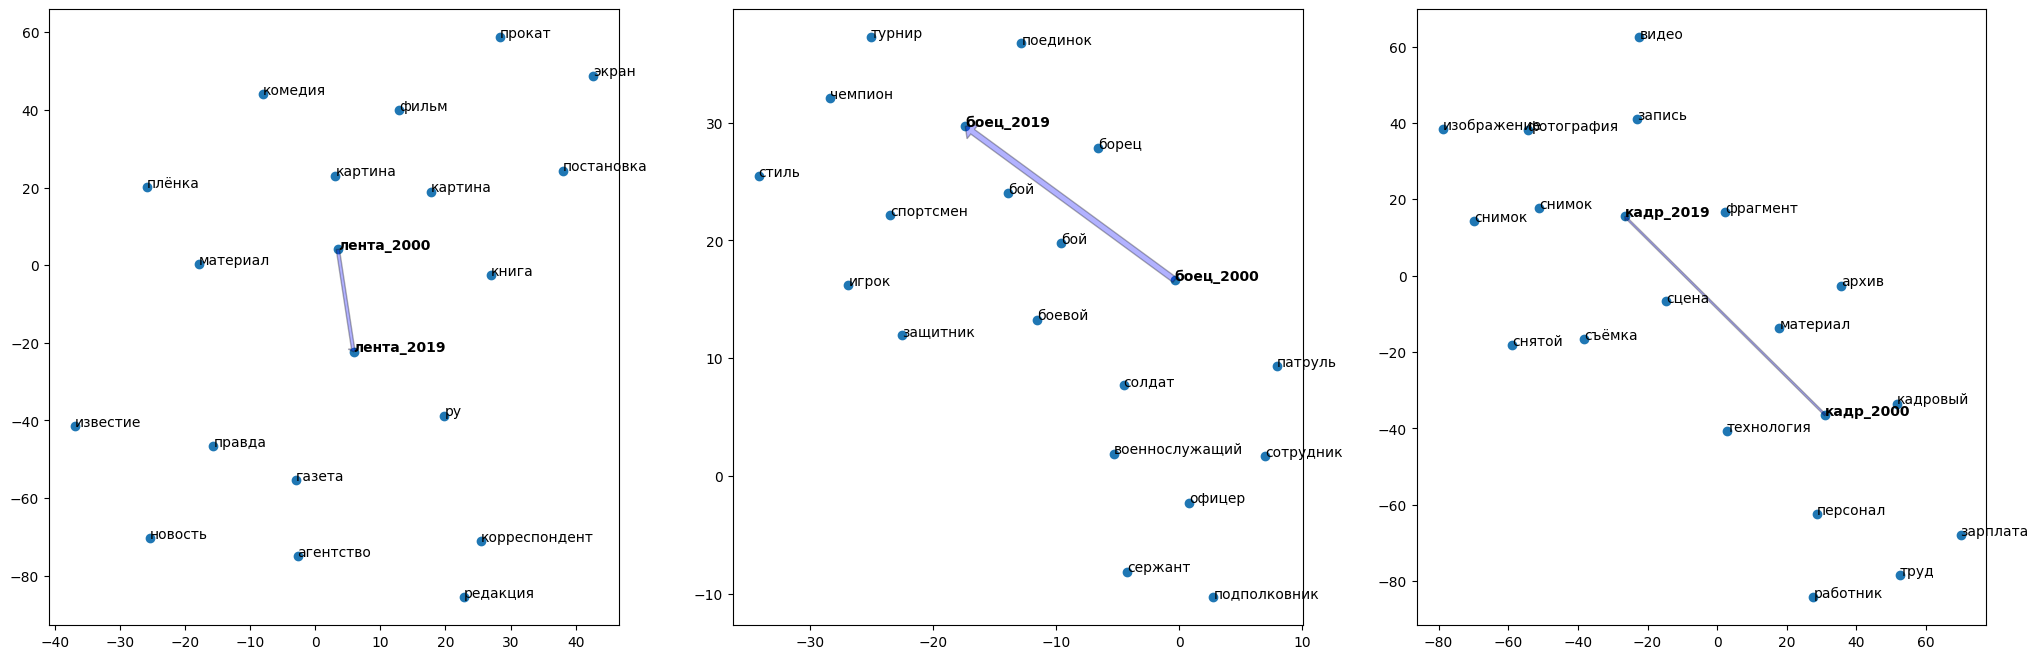

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

words = ['лента', 'боец', 'кадр']

list_2000 = list(vectors_2000.items())
words_2000 = list(map(lambda x: x[0], list_2000))
embeddings_2000 = list(map(lambda x: x[1], list_2000))

list_2019 = list(vectors_2019.items())
words_2019 = list(map(lambda x: x[0], list_2019))
embeddings_2019 = list(map(lambda x: x[1], list_2019))

points = []
all_keys = []

for word in tqdm(words):
    K_2000 = cosine_similarity([vectors_2000[word]],embeddings_2000)
    K_2019 = cosine_similarity([vectors_2019[word]],embeddings_2019)

    wids_2000 = np.argsort(-abs(K_2000[0]))
    wids_2000 = wids_2000[0:10]
    w_closest_2000 = [words_2000[w] for w in wids_2000[1:]]

    wids_2019 = np.argsort(-abs(K_2019[0]))
    wids_2019 = wids_2019[0:10]
    w_closest_2019 = [words_2019[w] for w in wids_2019[1:]]

    all_words = w_closest_2000
    all_words.extend(w_closest_2019)
    all_words.extend([f'{word}_2000', f'{word}_2019'])
    
    embeds_2000 = [embeddings_2000[w] for w in wids_2000[1:]]
    embeds_2019 = [embeddings_2019[w] for w in wids_2019[1:]]

    all_embeds = embeds_2000
    all_embeds.extend(embeds_2019)
    all_embeds.extend([vectors_2000[word], vectors_2019[word]])

    # Fit t-SNE
    mat = np.array(all_embeds)
    model = TSNE(n_components=2, random_state=0, init='pca', perplexity=10)
    fitted = model.fit_transform(mat)
    points.append(fitted)
    all_keys.append(all_words)

fig, ax = plt.subplots(1, 3)

fig.set_figheight(8)
fig.set_figwidth(25)

for j in range(3):
    fitted = points[j]
    x = fitted[:, 0]
    y = fitted[:, 1]
    keys = all_keys[j]

    ax[j].scatter(x, y)

    for i, txt in enumerate(keys):
        if len(keys) - i <= 2:
            ax[j].annotate(txt, (x[i], y[i]), weight='bold')
        else:
            ax[j].annotate(txt, (x[i], y[i]))
    
    ax[j].arrow(fitted[-2, 0], fitted[-2, 1], (fitted[-1, 0] - fitted[-2, 0]), 
              (fitted[-1, 1] - fitted[-2, 1]), facecolor='blue', alpha=0.3, width=0.5,
              head_length=0.75, length_includes_head=True)
fig.savefig(f'/content/gdrive/MyDrive/Colab Notebooks/HSE/Final/news_bert.png')